In [2]:
import os
import numpy as np 
import struct
import matplotlib.pyplot as plt
from array import array
import random

In [3]:
class MNIST:
    def __init__(self, path):
        self.path = path
        self.train_images_path = f'{self.path}/train-images.idx3-ubyte'
        self.train_labels_path = f'{self.path}/train-labels.idx1-ubyte'
        self.test_images_path = f'{self.path}/t10k-images.idx3-ubyte'
        self.test_labels_path = f'{self.path}/t10k-labels.idx1-ubyte'
        
    def vectorize(self, x):
        y = np.zeros((10,1))
        y[x] = 1
        return y
        
    def load(self, images_path, labels_path):
        with open(labels_path, 'rb') as f:
            magic, size = struct.unpack('>II', f.read(8))
            
            if magic != 2049:
                raise ValueError(f'bad magic number, expected 2049 got {magic}')
            
            labels = [self.vectorize(x) for x in array('B', f.read())]
        
        with open(images_path, 'rb') as f:
            magic, size, rows, cols = struct.unpack('>IIII', f.read(16))
            
            if magic != 2051: 
                raise ValueError(f'bad magic number, expected 2051 got {magic}')
            
            image_data = array('B', f.read())
            images = []
            for i in range(size):
                img = np.array(image_data[i * rows * cols : (i+1) * rows * cols]).reshape(784, 1) / 255
                images.append(img)
            images = np.array(images) 
        
        return list(zip(images, labels))
    
    def load_train(self):
        return self.load(self.train_images_path, self.train_labels_path)
    
    def load_test(self):
        return self.load(self.test_images_path, self.test_labels_path)

In [4]:
class DifferentiableFunction:
    def __init__(self, f, df):
        self.f = f
        self.deriv = df
        
    def __call__(self, *args):
        return self.f(*args)
    
sigma = lambda z: 1.0/(1.0 + np.exp(-z))
    
squared_loss = DifferentiableFunction(lambda y, yhat: (1/2)*np.linalg.norm(yhat - y)**2, lambda y, yhat: yhat - y)
sigmoid = DifferentiableFunction(sigma, lambda z: sigma(z) * (1 - sigma(z)))
relu = DifferentiableFunction(lambda z: z * (z > 0.5), lambda z: 1 * (z > 0.5))

In [5]:
class NeuralNet:
    def __init__(self, sizes, phis, weights=None, biases=None):
        self.sizes = sizes
        self.n = len(sizes) - 1
        self.phis = phis
        self.weights = [np.random.randn(sizes[i+1], sizes[i]) for i in range(self.n)]
        self.biases = [np.random.randn(sizes[i+1], 1) for i in range(self.n)]
    
    def backprop(self, x, y, loss):
        weight_deriv = [np.zeros(w.shape) for w in self.weights]
        bias_deriv = [np.zeros(b.shape) for b in self.biases]
        zs = []
        a = x
        acts = [x]
        
        # forward pass
        for w, b, phi in zip(self.weights, self.biases, self.phis):
            z = w @ a + b
            a = phi(z)
            zs.append(z)
            acts.append(a)
                                
        # backward pass
        delta = loss.deriv(y, acts[-1]) * self.phis[-1].deriv(zs[-1])
        bias_deriv[-1] = delta
        weight_deriv[-1] = delta @ acts[-2].T
        for l in range(2, len(self.sizes)):
            z = zs[-l]
            phi = self.phis[-l]
            delta = (self.weights[-l+1].T @ delta) * phi.deriv(z)
            bias_deriv[-l] = delta
            weight_deriv[-l] = delta @ acts[-l-1].T
        
        return weight_deriv, bias_deriv
    
    def learn(self, dataset, epochs=2, loss=squared_loss, eta=5, minibatch_size=10):
        N = len(dataset)
        for i in range(epochs):
            random.shuffle(dataset)
            for j in range(0, N, minibatch_size):
                minibatch = dataset[j:j+minibatch_size]
                self.learn_minibatch(minibatch, loss, eta)
            print(f'Epoch {i}: accuracy = {self.test(dataset)}')
    
    def learn_minibatch(self, minibatch, loss, eta):
        dw = [np.zeros(w.shape) for w in self.weights]
        db = [np.zeros(b.shape) for b in self.biases]
        
        for x, y in minibatch:
            weight_deriv, bias_deriv = self.backprop(x, y, loss)
            for l in range(self.n):
                dw[l] += weight_deriv[l]
                db[l] += bias_deriv[l]
        
        for l in range(self.n):
            self.weights[l] -= (eta/len(minibatch)) * dw[l]
            self.biases[l] -= (eta/len(minibatch)) * db[l]
        
    def predict(self, a):
        for w, b, phi in zip(self.weights, self.biases, self.phis):
            a = phi(w @ a + b)
        return a  
    
    def test(self, test_data):
        return sum(int(np.argmax(self.predict(x)) == np.argmax(y)) for x, y in test_data) / len(test_data)
        

In [8]:
mnist = MNIST('data')
dataset = mnist.load_train()

nn = NeuralNet([784, 30, 10], [sigmoid, sigmoid])
nn.learn(dataset, minibatch_size=10, epochs=10, eta=3)

Epoch 0: accuracy = 0.90485
Epoch 1: accuracy = 0.9254
Epoch 2: accuracy = 0.9382166666666667
Epoch 3: accuracy = 0.9391166666666667
Epoch 4: accuracy = 0.94595
Epoch 5: accuracy = 0.94815
Epoch 6: accuracy = 0.9518166666666666
Epoch 7: accuracy = 0.9543666666666667
Epoch 8: accuracy = 0.9553166666666667
Epoch 9: accuracy = 0.9593666666666667


the label is 7 and the model predicts 7
the total accuracy over the test data is 0.9473


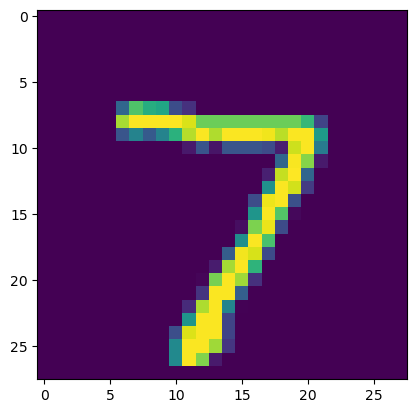

In [9]:
test_data = mnist.load_test()
img, label = test_data[0]
plt.imshow(img.reshape(28,28))
print(f'the label is {np.argmax(label)} and the model predicts {np.argmax(nn.predict(img))}')
print(f'the total accuracy over the test data is {nn.test(test_data)}')